In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Here we did put all the datasets in one dataframe
#including targets and features

import pandas as pd

file_paths = {
    "sp500_df": "/content/drive/My Drive/S&P 500 Datasets/S&P 500 Futures 2016 24.csv",
    "crudeoil_df": "/content/drive/My Drive/S&P 500 Datasets/Commodities Crude Oil WTI Futures 2016 24.csv",
    "gold_df": "/content/drive/My Drive/S&P 500 Datasets/Commodities Gold Futures 2016 24.csv",
    "eur_df": "/content/drive/My Drive/S&P 500 Datasets/Forex EUR_USD 2016 24.csv",
    "gbp_df": "/content/drive/My Drive/S&P 500 Datasets/Forex GBP_USD 2016 24.csv",
    "cny_df": "/content/drive/My Drive/S&P 500 Datasets/Forex USD_CNY 2016 24.csv",
    "jpy_df": "/content/drive/My Drive/S&P 500 Datasets/Forex USD_JPY 2016 24.csv",
    "usidx_df": "/content/drive/My Drive/S&P 500 Datasets/US Dollar Index 2016 24.csv",
}

dfs = {key: pd.read_csv(path) for key, path in file_paths.items()}

In [5]:
#handling missing values, backward and forward fill method


# Step 1: Inspect missing values for each dataframe
for key, df in dfs.items():
    print(f"Missing values in {key} before fill:")
    print(df.isnull().sum())

# Step 2: Apply ffill + bfill to each DataFrame in the dictionary
dfs = {key: df.ffill().bfill() for key, df in dfs.items()}

# Step 3: Confirm missing values handled
for key, df in dfs.items():
    print(f"Missing values in {key} after fill:")
    print(df.isnull().sum())


Missing values in sp500_df before fill:
Date         0
Price        0
Open         0
High         0
Low          0
Vol.        86
Change %     0
dtype: int64
Missing values in crudeoil_df before fill:
Date             0
Crude_Price      0
Open             0
High             0
Low              0
Vol.           106
Change %         0
dtype: int64
Missing values in gold_df before fill:
Date          0
Gold_Price    0
Open          0
High          0
Low           0
Vol.          2
Change %      0
dtype: int64
Missing values in eur_df before fill:
Date            0
EUR_Price       0
Open            0
High            0
Low             0
Vol.         2287
Change %        0
dtype: int64
Missing values in gbp_df before fill:
Date            0
GBP_Price       0
Open            0
High            0
Low             0
Vol.         2287
Change %        0
dtype: int64
Missing values in cny_df before fill:
Date            0
CNY_Price       0
Open            0
High            0
Low             0
Vol.   

"for key, df in dfs.items():\n    dfs[key] = df.fillna(method='ffill').fillna(method='bfill')"

In [ ]:
## Using datetime as common column to merge the datasets by setting the index.

for key, df in dfs.items():
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

In [ ]:
#dataset merge using the created dataframe

combined_df = dfs['sp500_df']
for key in ['gold_df', 'crudeoil_df', 'eur_df', 'gbp_df', 'cny_df', 'jpy_df', 'usidx_df']:
    combined_df = combined_df.join(dfs[key], how='inner', rsuffix=f'_{key}')

In [ ]:
## checking the numerical columns & filling remaining with NaNs; forward fill

for col in combined_df.columns:
    if combined_df[col].dtype == object:
        combined_df[col] = (
            combined_df[col].str.replace(',', '')
            .str.replace('%', '')
            .str.replace('M', 'e6')
            .str.replace('B', 'e9')
        )
        combined_df[col] = pd.to_numeric(combined_df[col], errors='coerce')

combined_df.fillna(method='ffill', inplace=True)

<ipython-input-66-453531c9439e>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df.fillna(method='ffill', inplace=True)


             Price         Open         High          Low          Vol.  \
count  2236.000000  2236.000000  2236.000000  2236.000000  2.236000e+03   
mean   3483.119893  3440.848730  3464.056252  3416.913462  1.633864e+06   
std    1032.297018   999.815313  1004.907342   994.624833  4.996143e+05   
min    1824.500000  1827.250000  1847.250000  1802.500000  1.000000e+06   
25%    2644.375000  2645.750000  2670.062500  2623.250000  1.280000e+06   
50%    3213.500000  3212.625000  3231.250000  3190.250000  1.560000e+06   
75%    4336.250000  4219.687500  4248.437500  4191.312500  1.810000e+06   
max    5814.250000  5807.000000  5830.000000  5782.000000  5.720000e+06   

          Change %   Gold_Price  Open_gold_df  High_gold_df  Low_gold_df  ...  \
count  2236.000000  2236.000000   2236.000000   2236.000000  2236.000000  ...   
mean      0.094866  1629.636136   1629.734682   1640.186941  1619.121758  ...   
std       1.232950   352.265777    352.335429    355.269566   349.359434  ...   


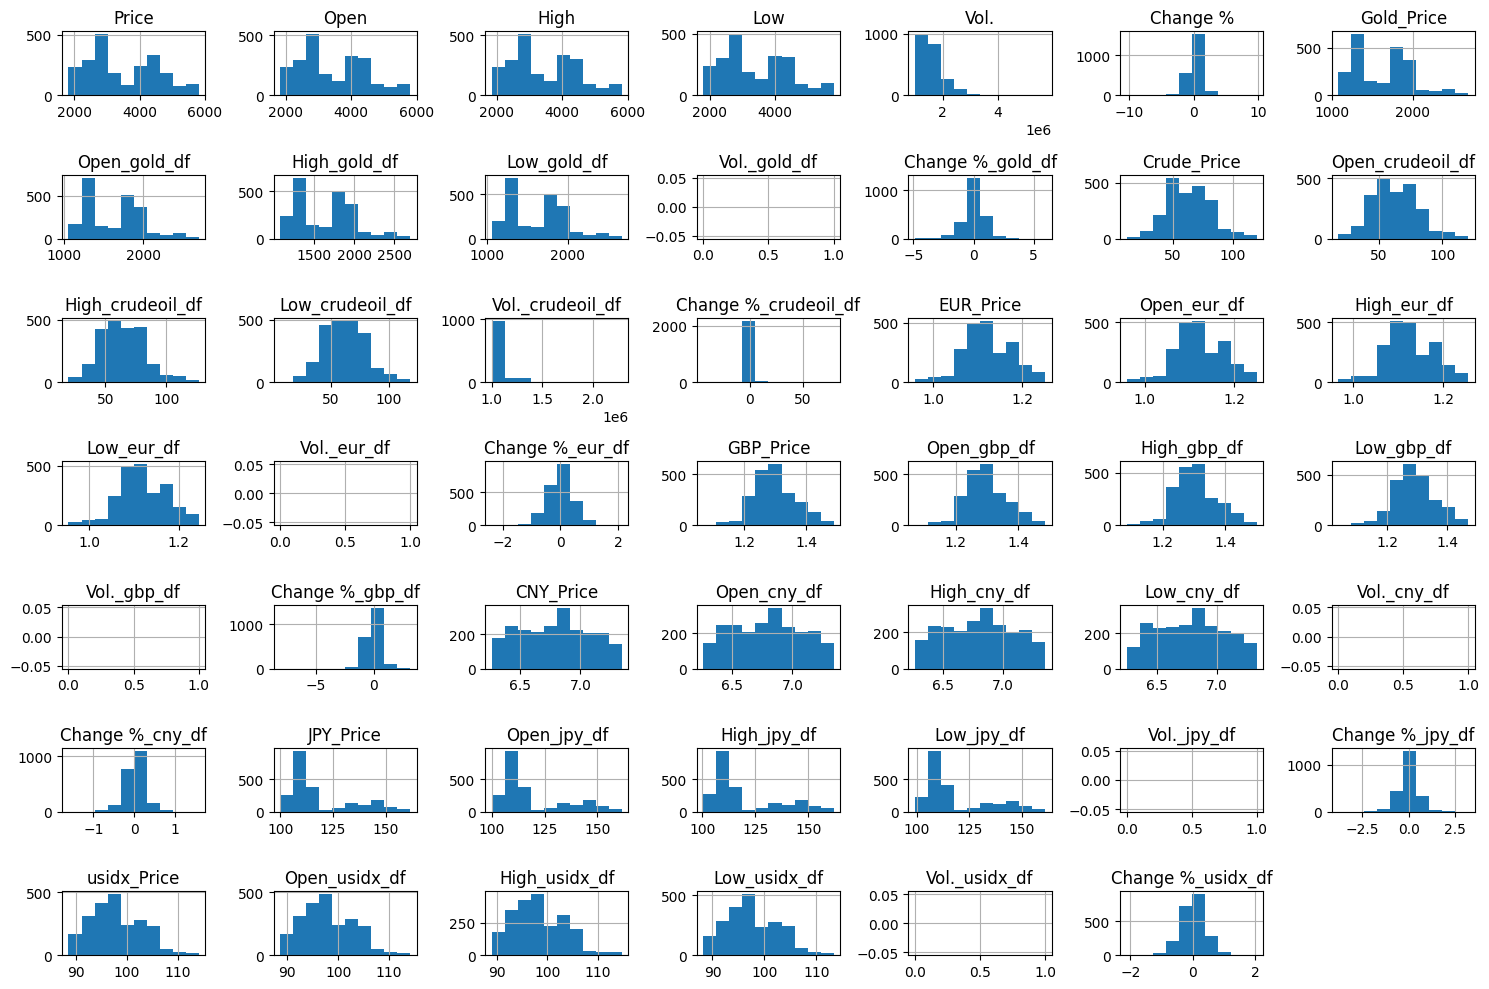

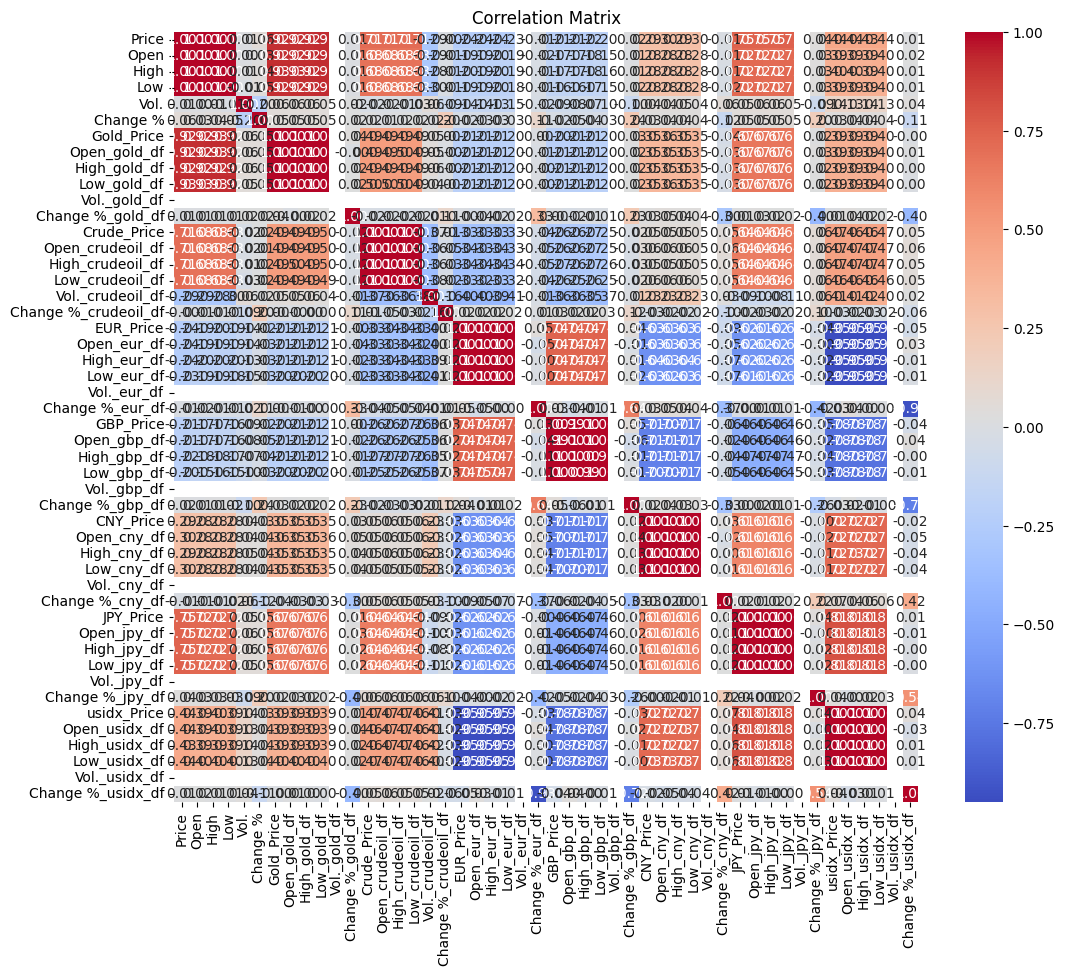

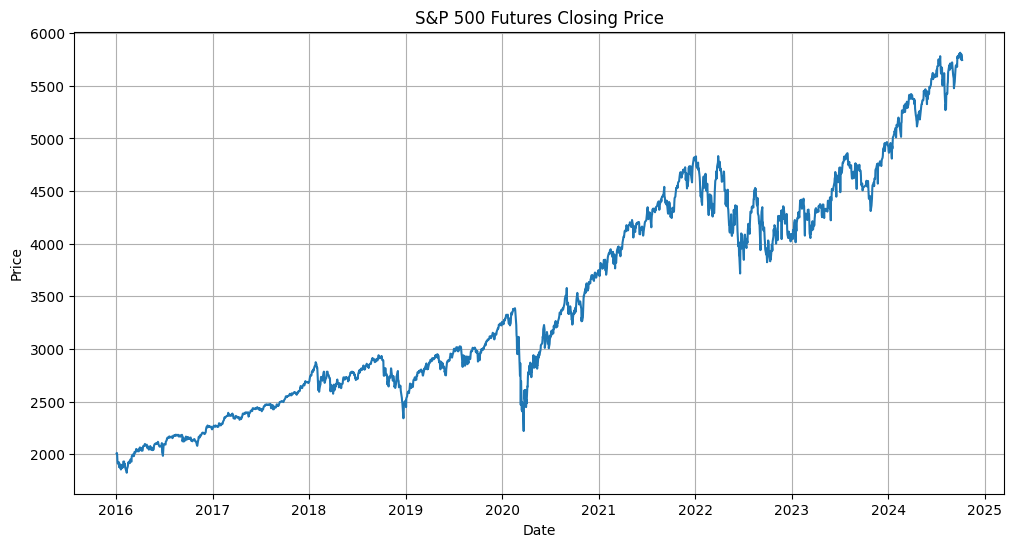

In [ ]:
# EDA for modeliing and feature enginering

import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistics
print(combined_df.describe())

# Histograms for numerical features
combined_df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(combined_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Time series plot of S&P 500 closing price
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['Price'])
plt.title('S&P 500 Futures Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()



In [ ]:
## feature engineering for fewer important features.

combined_df['Momentum_10d'] = combined_df['Price'] - combined_df['Price'].shift(10)
combined_df['Momentum_5d'] = combined_df['Price'] - combined_df['Price'].shift(5)
combined_df['SMA_10'] = combined_df['Price'].rolling(window=10).mean()
combined_df['SMA_5'] = combined_df['Price'].rolling(window=5).mean()
combined_df['SMA_20'] = combined_df['Price'].rolling(window=20).mean()
combined_df['Price_MA5'] = combined_df['Price'].rolling(window=5).mean()
combined_df['Price_volatility_7d'] = combined_df['Price'].rolling(window=7).std()
combined_df['Gold_to_SP500'] = combined_df['Gold_Price'] / combined_df['Price']
combined_df['DollarIndex_to_SP500'] = combined_df['usidx_Price'] / combined_df['Price']
combined_df['RSI'] = 100 - (100 / (1 + combined_df['Price'].diff().where(combined_df['Price'].diff() > 0, 0).rolling(14).mean() /
                                    (-combined_df['Price'].diff().where(combined_df['Price'].diff() < 0, 0).rolling(14).mean())))

combined_df.head()

,Price,Open,High,Low,Vol.,Change %,Gold_Price,Open_gold_df,High_gold_df,Low_gold_df,...,Momentum_10d,Momentum_5d,SMA_10,SMA_5,SMA_20,Price_MA5,Price_volatility_7d,Gold_to_SP500,DollarIndex_to_SP500,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2024-10-07,5744.75,5802.00,5808.00,5734.25,1210000.0,-0.95,2666.0,2671.7,2679.2,2657.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.464076,0.017849,NaN
2024-10-04,5800.00,5745.75,5804.75,5741.00,1460000.0,0.88,2667.8,2675.7,2690.6,2651.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.459966,0.017676,NaN
2024-10-03,5749.50,5769.50,5772.75,5725.75,1420000.0,-0.19,2679.2,2679.9,2683.4,2657.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.465988,0.017739,NaN
2024-10-02,5760.25,5760.25,5773.25,5724.00,1250000.0,0.01,2669.7,2684.6,2684.8,2662.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.463469,0.017652,NaN
2024-10-01,5759.75,5807.00,5822.50,5733.00,1950000.0,-0.94,2690.3,2656.1,2694.7,2653.8,...,NaN,NaN,NaN,5762.85,NaN,5762.85,NaN,0.467086,0.017568,NaN


In [ ]:
# setting binary target for daily prediction
# yesterday's clsoing for today == 0, more than yesterday for today == 1, less
# than yesterday's for today == -1.

combined_df['Binary Movement'] = 0
combined_df.loc[combined_df['Price'].diff() > 0, 'Binary Movement'] = 1
combined_df.loc[combined_df['Price'].diff() < 0, 'Binary Movement'] = -1



In [ ]:
## Drop unnecessary or high-correlation features to reduce overfitting
## dropping Change% as told in checkpoint 2, for checking changes in output


drop_columns = ['Open', 'High', 'Low', 'Vol.', 'Change %','Price']
combined_df.drop(columns=[col for col in combined_df.columns if any(suffix in col for suffix in drop_columns)], inplace=True)

In [ ]:
# Dropping rows with NaNs after feature engineering

combined_df.dropna(inplace=True)

In [ ]:
# Preparing for modeling

X = combined_df.drop(['Binary Movement'], axis=1)
y = combined_df['Binary Movement']

In [ ]:
# defining the scaler, defining models with parameters, iterating with each scaler,
# using best scaler to get the accuracies

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from sklearn.model_selection import train_test_split


scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(),
    'MaxAbsScaler': MaxAbsScaler()
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': (LogisticRegression(solver='saga', max_iter=1000), {
        'model__C': [0.01, 0.1, 1, 10],
        'model__penalty': ['l1', 'l2']
    }),
    'Linear SVM': (LinearSVC(max_iter=1000), {
        'model__C': [0.01, 0.1, 1, 10],
        'model__penalty': ['l1', 'l2']
    })
}

results = []

for model_name, (model, param_grid) in models.items():
    best_scaler = None
    best_score = -np.inf

    for scaler_name, scaler in scalers.items():
        pipeline = Pipeline([
            ('scaler', scaler),
            ('model', model)
        ])
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        if grid_search.best_score_ > best_score:
            best_score = grid_search.best_score_
            best_scaler = scaler_name
            best_params = grid_search.best_params_

    best_scaler_instance = scalers[best_scaler]
    pipeline = Pipeline([
        ('scaler', best_scaler_instance),
        ('model', model)
    ])

    pipeline.set_params(**best_params)
    pipeline.fit(X_train, y_train)

    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    results.append({
        'Model': model_name,
        'Best Scaler': best_scaler,
        'Best Parameters': best_params,
        'Train Accuracy': accuracy_score(y_train, y_train_pred),
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Train F1': f1_score(y_train, y_train_pred, average='weighted'),
        'Test F1': f1_score(y_test, y_test_pred, average='weighted')
    })

for result in results:
    print(f"Model: {result['Model']}")
    print(f"Best Scaler: {result['Best Scaler']}")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Train Accuracy: {result['Train Accuracy']:.4f}")
    print(f"Test Accuracy: {result['Test Accuracy']:.4f}")
    print(f"Train F1: {result['Train F1']:.4f}")
    print(f"Test F1: {result['Test F1']:.4f}")
    print("-" * 60)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Model: Logistic Regression
Best Scaler: StandardScaler
Best Parameters: {'model__C': 10, 'model__penalty': 'l1'}
Train Accuracy: 0.7124
Test Accuracy: 0.6667
Train F1: 0.7057
Test F1: 0.6592
------------------------------------------------------------
Model: Linear SVM
Best Scaler: StandardScaler
Best Parameters: {'model__C': 10, 'model__penalty': 'l2'}
Train Accuracy: 0.7073
Test Accuracy: 0.6667
Train F1: 0.7000
Test F1: 0.6588
------------------------------------------------------------
